<a href="https://colab.research.google.com/github/t-willi/Simula/blob/main/AE_V3_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
#normlaize data over all used files, either global max or lead maximum
#use weights and biasas

In [142]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import torchvision
from torchvision import datasets, models, transforms
from torchvision.transforms import ToTensor
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from timeit import default_timer as timer 
import glob
import torch.optim as optim
from sklearn.preprocessing import normalize
from sklearn.preprocessing import MinMaxScaler
from random import shuffle

import requests
import zipfile
from pathlib import Path

if torch.cuda.is_available()==True:
  device="cuda:0"
else:
  device ="cpu"

In [100]:
l=[1,2,3,4,5,6,7,8,9,10,2,3]
shuffle(l)
cut_at=0.8
lenght = len(l)
cutof=int(lenght*cut_at)
list_left=l[0:cutof]
list_right=l[cutof:lenght]
list_left,list_right

([5, 1, 2, 9, 7, 3, 6, 4, 2], [10, 3, 8])

In [7]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [8]:
# Setup path to data folder
data_path = Path("data/")
train_path = data_path / "train_data"


# If the image folder doesn't exist, download it and prepare it... 
if train_path.is_dir():
    print(f"{train_path} directory exists.")
else:
    print(f"Did not find {train_path} directory, creating one...")
    train_path.mkdir(parents=True, exist_ok=True)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile("/content/gdrive/MyDrive/Simula/sub_data.zip", "r") as zip_ref:
        print(f"Unzipping data to folder...") 
        zip_ref.extractall(train_path)

drive.flush_and_unmount()




data/train_data directory exists.


In [9]:
df = pd.read_csv("/content/data/train_data/sub_data/test/149849.asc",sep=" ",header=None)
max=df.values.max()
max

1705

In [143]:
dataframe_list=[]
data_dir_test="/content/data/train_data/sub_data/test"
data_dir_train = "/content/data/train_data/sub_data/train"
files_test=glob.glob(data_dir_test + '/*.asc')
files_train=glob.glob(data_dir_train + '/*.asc')
files=[*files_test,*files_train]
for file in files:
  temp_df=pd.read_csv(file,sep=" ")
  dataframe_list.append(temp_df)
all_df=pd.concat(dataframe_list,axis=1)
global_max = all_df.values.max()


In [11]:
# (all_df/global_max).values.max()

In [12]:
# all_df_normalized=all_df/global_max
# all_df_normalized.values.max()

In [13]:
# def normalize_df_per_column(df):
#   for i,k in enumerate(df.columns):
#     max=df.iloc[:,i].max()
#     min=df.iloc[:,i].min()
#     df.iloc[:,i] = df.iloc[:,i].apply(lambda x: ((x-min)/(max-min)))
#   return df


In [14]:
# def normalize_list(l):
#   max=max(l)
#   min=min(l)
#   l=l.apply(lambda x:((x-min)/(max-min)))
#   return l



In [15]:
# dir = "/content/train"
# files=glob.glob(dir + '/*.csv')
# for file in files:
#   df=pd.read_csv(file,sep=" ")
#   df=df.iloc[:,1]

# files[0]





In [42]:
bulian=False
if bulian is True:
  print("true")
if bulian is not True:
  print("not true")

not true


In [144]:
# Create custom dataset class to load ECG data into dataset, containing 
# input tensor with lead 1 and output tensor with desired other leads
class Custom_dataset(Dataset):
    def __init__(self, data_dir,max_value=global_max,column=3,split=False,train=True):
      #get all files from directory loaded in all_files list
      self.column=column
      self.max_value=max_value
      self.files = glob.glob(data_dir + '/*.asc')
      self.len=len(self.files)
      self.cut=int(self.len*0.8)
      self.train_files=self.files[0:self.cut]
      self.test_files=self.files[self.cut:self.len]
      self.train=train
      self.split=split

    def __len__(self):
      if self.split is True:
        if self.train is True:
          return len(self.train_files)
        if self.train is not True:
          return len(self.test_files)
      if self.split is not True:
        return len(self.files)

    def __getitem__(self,idx):
      #turn list of dataframes into Tensor
      if self.split is True:
        if self.train is True:
          temp_df=pd.read_csv(self.train_files[idx],sep=" ")
        if self.train is not True:
          temp_df=pd.read_csv(self.test_files[idx],sep=" ")
      if self.split is not True:
        temp_df=pd.read_csv(self.files[idx],sep=" ")
      #temp_df/=self.max_value
      #load input tensor
      temp_list_in=temp_df.iloc[:,1]
      #temp_list_in=normalize([temp_list_in], norm="max")
      temp_tensor_in = torch.tensor(temp_list_in,dtype=torch.float32)
      #load label Tensor
      temp_list_out=temp_df.iloc[:,self.column].values
      #temp_list_out=normalize([temp_list_out], norm="max")
      temp_tensor_out=torch.tensor(temp_list_out,dtype=torch.float32)
      #combine input and label and output
      temp_tensor_pair= temp_tensor_in,temp_tensor_out
      return temp_tensor_pair

In [145]:
train_dir="/content/data/train_data/sub_data/train"
test_dir="/content/data/train_data/sub_data/test"

In [146]:
train_dataset = Custom_dataset(data_dir="/content/data/train_data/sub_data/train",split=False,train=True)
x,y=train_dataset[0]

In [147]:
len(train_dataset)

2500

In [109]:
#create trainingsets for all 8 conversions
#1 to 1
datasetlist = []
train_dataset1_1 = Custom_dataset(data_dir=train_dir,column=1)
datasetlist.append(train_dataset1_1)
train_dataset1_2 = Custom_dataset(data_dir=train_dir,column=2)
datasetlist.append(train_dataset1_2)
train_dataset1_3 = Custom_dataset(data_dir=train_dir,column=3)
datasetlist.append(train_dataset1_3)
train_dataset1_4 = Custom_dataset(data_dir=train_dir,column=4)
datasetlist.append(train_dataset1_4)
train_dataset1_5 = Custom_dataset(data_dir=train_dir,column=5)
datasetlist.append(train_dataset1_5)
train_dataset1_6 = Custom_dataset(data_dir=train_dir,column=6)
datasetlist.append(train_dataset1_6)
train_dataset1_7 = Custom_dataset(data_dir=train_dir,column=7)
datasetlist.append(train_dataset1_7)
train_dataset1_8 = Custom_dataset(data_dir=train_dir,column=8)
datasetlist.append(train_dataset1_8)


In [60]:
len(train_dataset1_1)

2500

In [148]:
#check for shape of the data in dataset
x,y=datasetlist[1][0]
x.shape,x.dtype,y.shape,y.dtype,x,y

NameError: ignored

In [110]:
from torch.utils.data.dataloader import DataLoader
BATCH_SIZE = 32
dataloaderlist = []
#turn datasets into iterables
for data in datasetlist:
  train_dataloader = DataLoader(data,
                              batch_size=BATCH_SIZE,
                              shuffle=True
                              )
  dataloaderlist.append(train_dataloader)


In [111]:
x,y = next(iter(dataloaderlist[1]))
#x.shape,x.dtype,x,y.shape,y.dtype,y
x.shape,x.dtype,y.shape,y.dtype,x,y

(torch.Size([32, 4999]),
 torch.float32,
 torch.Size([32, 4999]),
 torch.float32,
 tensor([[-0.0022, -0.0086, -0.0220,  ...,  0.0020,  0.0058, -0.0056],
         [-0.0080, -0.0128, -0.0154,  ...,  0.0569,  0.0437,  0.0251],
         [ 0.0226,  0.0243,  0.0094,  ..., -0.0142, -0.0152, -0.0257],
         ...,
         [-0.0196, -0.0277, -0.0393,  ..., -0.0351, -0.0359, -0.0435],
         [-0.0052, -0.0080, -0.0204,  ..., -0.0030, -0.0054, -0.0144],
         [ 0.0094, -0.0018, -0.0257,  ...,  0.0186,  0.0237,  0.0078]]),
 tensor([[ 0.0102,  0.0054, -0.0002,  ...,  0.0030,  0.0124,  0.0122],
         [ 0.0050, -0.0028, -0.0166,  ..., -0.0076, -0.0058,  0.0128],
         [-0.0002, -0.0136, -0.0150,  ...,  0.0120,  0.0136,  0.0130],
         ...,
         [-0.0042, -0.0082, -0.0140,  ..., -0.0018, -0.0058, -0.0046],
         [ 0.0086,  0.0110,  0.0066,  ...,  0.0110,  0.0138,  0.0140],
         [ 0.0076,  0.0082,  0.0094,  ...,  0.0000,  0.0074,  0.0180]]))

In [149]:
"""
Here, we define the autoencoder model.This model is taken from "https://github.com/L1aoXingyu/pytorch-beginner/blob/master/08-AutoEncoder/simple_autoencoder.py"
"""
class ECG_AE_v1(nn.Module):
    def __init__(self):
        super(ECG_AE_v1, self).__init__()
        self.AE = nn.Sequential(
            nn.Linear(4999, 128),
            nn.ReLU(),
            nn.Linear(128,20),
            nn.ReLU(),
            nn.Linear(20,10),
            nn.ReLU(),
            nn.Linear(10,20),
            nn.ReLU(),
            nn.Linear(20,128),
            nn.ReLU(),
            nn.Linear(128,4999),
        )


    def forward(self, x):
        x = self.AE(x)
        return x


model = ECG_AE_v1().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)



In [113]:
try: 
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo

from torchinfo import summary
summary(model, input_size=[1,4999]) # do a test pass through of an example input size 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Layer (type:depth-idx)                   Output Shape              Param #
ECG_AE_v1                                [1, 4999]                 --
├─Sequential: 1-1                        [1, 4999]                 --
│    └─Linear: 2-1                       [1, 128]                  640,000
│    └─ReLU: 2-2                         [1, 128]                  --
│    └─Linear: 2-3                       [1, 20]                   2,580
│    └─ReLU: 2-4                         [1, 20]                   --
│    └─Linear: 2-5                       [1, 10]                   210
│    └─ReLU: 2-6                         [1, 10]                   --
│    └─Linear: 2-7                       [1, 20]                   220
│    └─ReLU: 2-8                         [1, 20]                   --
│    └─Linear: 2-9                       [1, 128]                  2,688
│    └─ReLU: 2-10                        [1, 128]                  --
│    └─Linear: 2-11                      [1, 4999]                 644,8

In [123]:
def train_loop(Epochs=10,dataloader=None):
  model = ECG_AE_v1().to(device)
  from tqdm.auto import tqdm
  for epoch in tqdm(range(Epochs)):
    print(f"Epoch:{epoch}")
    train_loss=0
    for batch, (X,y) in enumerate(dataloader): 
      X, y = X.to(device), y.to(device) 
      model.train()
      output=model(X)
      loss = criterion(output,y)
      train_loss += loss
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
    #average loss per batch
    train_loss /= len(train_dataloader)
    print(f"\nTrain loss: {train_loss:.5f}")
  return model



    



In [14]:
list_of_models = []
for dataloader in dataloaderlist:
  model = train_loop(dataloader=dataloader)
  list_of_models.append(model)





  0%|          | 0/10 [00:00<?, ?it/s]

Epoch:0

Train loss: 0.02915
Epoch:1

Train loss: 0.02855
Epoch:2

Train loss: 0.02741
Epoch:3

Train loss: 0.02842
Epoch:4

Train loss: 0.02743
Epoch:5

Train loss: 0.02841
Epoch:6

Train loss: 0.02826
Epoch:7

Train loss: 0.02780
Epoch:8

Train loss: 0.02884
Epoch:9

Train loss: 0.02876


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch:0

Train loss: 0.02871
Epoch:1

Train loss: 0.03024
Epoch:2

Train loss: 0.03091
Epoch:3

Train loss: 0.02907
Epoch:4

Train loss: 0.03002
Epoch:5

Train loss: 0.02895
Epoch:6

Train loss: 0.02963
Epoch:7

Train loss: 0.02982
Epoch:8

Train loss: 0.02912
Epoch:9

Train loss: 0.02931


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch:0

Train loss: 0.02674
Epoch:1

Train loss: 0.02800
Epoch:2

Train loss: 0.02802
Epoch:3

Train loss: 0.02740
Epoch:4

Train loss: 0.02733
Epoch:5

Train loss: 0.02718
Epoch:6

Train loss: 0.02676
Epoch:7

Train loss: 0.02728
Epoch:8

Train loss: 0.02805
Epoch:9

Train loss: 0.02737


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch:0

Train loss: 0.03838
Epoch:1

Train loss: 0.03824
Epoch:2

Train loss: 0.03998
Epoch:3

Train loss: 0.03799
Epoch:4

Train loss: 0.04051
Epoch:5

Train loss: 0.03778
Epoch:6

Train loss: 0.04033
Epoch:7

Train loss: 0.03812
Epoch:8

Train loss: 0.03890
Epoch:9

Train loss: 0.03856


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch:0

Train loss: 0.03788
Epoch:1

Train loss: 0.03799
Epoch:2

Train loss: 0.03924
Epoch:3

Train loss: 0.03795
Epoch:4

Train loss: 0.03925
Epoch:5

Train loss: 0.03869
Epoch:6

Train loss: 0.03926
Epoch:7

Train loss: 0.03973
Epoch:8

Train loss: 0.03819
Epoch:9

Train loss: 0.03947


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch:0

Train loss: 0.02864
Epoch:1

Train loss: 0.02880
Epoch:2

Train loss: 0.03018
Epoch:3

Train loss: 0.02927
Epoch:4

Train loss: 0.02949
Epoch:5

Train loss: 0.03044
Epoch:6

Train loss: 0.02869
Epoch:7

Train loss: 0.03049
Epoch:8

Train loss: 0.02967
Epoch:9

Train loss: 0.02897


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch:0

Train loss: 0.02766
Epoch:1

Train loss: 0.02760
Epoch:2

Train loss: 0.02822
Epoch:3

Train loss: 0.02807
Epoch:4

Train loss: 0.02764
Epoch:5

Train loss: 0.02833
Epoch:6

Train loss: 0.02766
Epoch:7

Train loss: 0.02742
Epoch:8

Train loss: 0.02715
Epoch:9

Train loss: 0.02799


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch:0

Train loss: 0.02810
Epoch:1

Train loss: 0.02604
Epoch:2

Train loss: 0.02586
Epoch:3

Train loss: 0.02565
Epoch:4

Train loss: 0.02559
Epoch:5

Train loss: 0.02644
Epoch:6

Train loss: 0.02618
Epoch:7

Train loss: 0.02617
Epoch:8

Train loss: 0.02573
Epoch:9

Train loss: 0.02611


In [89]:
train_dataloader = dataloaderlist[2]
x,y=next(iter(train_dataloader))
x.shape,y.shape,x.dtype,y.dtype,x,y

/content/train/65.csv
/content/train/58.csv
/content/train/69.csv
/content/train/97.csv
/content/train/80.csv
/content/train/3.csv
/content/train/86.csv
/content/train/73.csv
/content/train/13.csv
/content/train/89.csv


(torch.Size([10, 1, 4999]),
 torch.Size([10, 1, 4999]),
 torch.float32,
 torch.float32,
 tensor([[[-0.1014, -0.0791, -0.0553,  ..., -0.0395, -0.0264, -0.0474]],
 
         [[-0.2661, -0.1769, -0.1082,  ..., -0.0263, -0.0058, -0.0292]],
 
         [[-0.2907, -0.2998, -0.3227,  ...,  0.3227,  0.3394,  0.2161]],
 
         ...,
 
         [[ 0.0215,  0.0554,  0.1052,  ...,  0.1075,  0.1459,  0.1109]],
 
         [[-0.2052, -0.1599, -0.0727,  ...,  0.0145,  0.0307,  0.0129]],
 
         [[ 0.0270,  0.0676,  0.1149,  ..., -0.0642, -0.0591, -0.0811]]]),
 tensor([[[ 0.0272,  0.0234, -0.0019,  ...,  0.0094,  0.0197,  0.0290]],
 
         [[ 0.2677,  0.2550,  0.2139,  ..., -0.0057,  0.0142,  0.0142]],
 
         [[-0.1382, -0.1284, -0.2487,  ...,  0.1041,  0.1203,  0.1706]],
 
         ...,
 
         [[ 0.0395,  0.0206,  0.0000,  ...,  0.0840,  0.0922,  0.0848]],
 
         [[ 0.1139,  0.1329,  0.0485,  ...,  0.1160,  0.1477,  0.1435]],
 
         [[-0.0119, -0.0055, -0.0421,  ...,  0.0421,  0

In [24]:
x,y=next(iter(train_dataloader))
x.shape,y.shape

(torch.Size([32, 4999]), torch.Size([32, 4999]))

In [125]:
# from tqdm.auto import tqdm
# #train and test loop
# Epochs = 50
# for epoch in tqdm(range(Epochs)):
#   print(f"Epoch:{epoch}")
#   train_loss=0
#   for batch, (X,y) in enumerate(train_dataloader):
#     X, y = X.to(device), y.to(device) 
#     model.train()
#     output=model(X)
#     loss = criterion(output,y)
#     train_loss += loss
#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()
#   #average loss per batch
#   train_loss /= len(train_dataloader)
#   #start testing
#   test_loss = 0
#   model.eval()
#   with torch.inference_mode():
#     for X,y in test_dataloader:
#       X, y = X.to(device), y.to(device) 
#       test_pred = model(X)
#       ##reshaping output from linear to 2d from 40000 to 8 times 5000
#       #test_pred=torch.reshape(test_pred,(10,1,8,4999))
#       ######
#       test_loss += criterion(test_pred,y)    
#     test_loss /= len(test_dataloader)

#   #print what is happening
#   print(f"\nTrain loss: {train_loss:.5f} |test_loss:{test_loss}" )
    




  0%|          | 0/50 [00:00<?, ?it/s]

Epoch:0

Train loss: 17278.06836 |test_loss:22168.283203125
Epoch:1

Train loss: 17341.19922 |test_loss:22113.697265625
Epoch:2

Train loss: 17355.20117 |test_loss:22154.546875
Epoch:3


ParserError: ignored

In [155]:
def train_model(Epochs=20,model=model,train_dataloader=train_dataloader,test_dataloader=test_dataloader):
  from tqdm.auto import tqdm
  #train and test loop
  for epoch in tqdm(range(Epochs)):
    print(f"Epoch:{epoch}")
    train_loss=0
    for batch, (X,y) in enumerate(train_dataloader):
      X, y = X.to(device), y.to(device) 
      model.train()
      output=model(X)
      loss = criterion(output,y)
      train_loss += loss
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
    #average loss per batch
    train_loss /= len(train_dataloader)
    #start testing
    test_loss = 0
    model.eval()
    with torch.inference_mode():
      for X,y in test_dataloader:
        X, y = X.to(device), y.to(device) 
        test_pred = model(X)
        ##reshaping output from linear to 2d from 40000 to 8 times 5000
        #test_pred=torch.reshape(test_pred,(10,1,8,4999))
        ######
        test_loss += criterion(test_pred,y)    
      test_loss /= len(test_dataloader)

    #print what is happening
    print(f"\nTrain loss: {train_loss:.5f} |test_loss:{test_loss}" )


In [151]:
train_dataset = Custom_dataset(data_dir=train_dir)
test_dataset = Custom_dataset(data_dir=test_dir)

In [152]:
from torch.utils.data.dataloader import DataLoader
BATCH_SIZE = 32
#turn datasets into iterables
train_dataloader = DataLoader(train_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=True
                              )
test_dataloader = DataLoader(test_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=True
                              )

In [116]:
data_path = Path("models/")
model_path = data_path / "model_1"
# If the image folder doesn't exist, download it and prepare it... 
if model_path.is_dir():
    print(f"{model_path} directory exists.")
else:
    print(f"Did not find {model_path} directory, creating one...")
    model_path.mkdir(parents=True, exist_ok=True)


models/model_1 directory exists.


In [120]:
torch.save(model.state_dict(), "/content/models/model1")

In [121]:
model = ECG_AE_v1().to(device)
model.load_state_dict(torch.load("/content/models/model1"))
model.eval()

ECG_AE_v1(
  (AE): Sequential(
    (0): Linear(in_features=4999, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=20, bias=True)
    (3): ReLU()
    (4): Linear(in_features=20, out_features=10, bias=True)
    (5): ReLU()
    (6): Linear(in_features=10, out_features=20, bias=True)
    (7): ReLU()
    (8): Linear(in_features=20, out_features=128, bias=True)
    (9): ReLU()
    (10): Linear(in_features=128, out_features=4999, bias=True)
  )
)

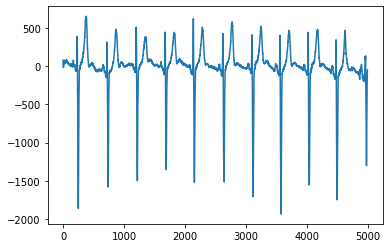

In [159]:
input,output = train_dataset[0]
input=output.tolist()
data=input
type(data)
plt.plot(data)
# plt.title("Input ECG lead1")

Text(0.5, 1.0, 'Output ECG trained for 20epochs on 50 datapoints')

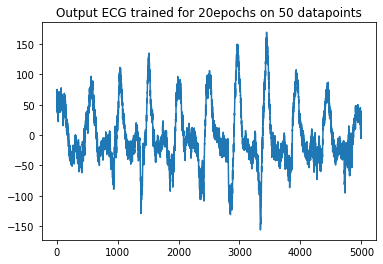

In [160]:
X,y=test_dataset[0]
model.to("cpu")
model.eval()
with torch.inference_mode():
  output=model(X)
output=output.tolist()
data=output
plt.plot(data)
plt.title("Output ECG trained for 20epochs on 50 datapoints")

In [ ]:
X,y=test_dataset[0]
model.to("cpu")
model.eval()
with torch.inference_mode():
  output=model(X)
output